# Iris Flower - Batch Prediction


In this notebook we will, 

1. Load the batch inference data that arrived in the last 24 hours
2. Predict the first Iris Flower found in the batch
3. Write the ouput png of the Iris flower predicted, to be displayed in Github Pages.

In [2]:
import pandas as pd
import hopsworks
import joblib

project = hopsworks.login()
fs = project.get_feature_store()

Connected. Call `.close()` to terminate connection gracefully.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/7337


Connected. Call `.close()` to terminate connection gracefully.


In [3]:
mr = project.get_model_registry()
model = mr.get_model("iris", version=1)
model_dir = model.download()
model = joblib.load(model_dir + "/iris_model.pkl")

Connected. Call `.close()` to terminate connection gracefully.

We are downloading the 'raw' iris data. We explicitly do not want transformed data, reading for training. 

So, let's download the iris dataset, and preview some rows. 

Note, that it is 'tabular data'. There are 5 columns: 4 of them are "features", and the "variety" column is the **target** (what we are trying to predict using the 4 feature values in the target's row).

In [37]:
feature_view = fs.get_feature_view(name="iris", version=1)

Now we will do some **Batch Inference**. 

We will read all the input features that have arrived in the last 24 hours, and score them.

In [59]:
import datetime
from PIL import Image

batch_data = feature_view.get_batch_data()

y_pred = model.predict(batch_data)

y_pred

2022-12-06 23:15:40,033 INFO: USE `learn_mlops_featurestore`
2022-12-06 23:15:41,179 INFO: SELECT `fg0`.`sepal_length` `sepal_length`, `fg0`.`sepal_width` `sepal_width`, `fg0`.`petal_length` `petal_length`, `fg0`.`petal_width` `petal_width`
FROM `learn_mlops_featurestore`.`iris_1` `fg0`


array(['Setosa', 'Versicolor', 'Virginica', 'Versicolor', 'Setosa',
       'Versicolor', 'Virginica', 'Versicolor', 'Setosa', 'Setosa',
       'Setosa', 'Setosa', 'Versicolor', 'Virginica', 'Setosa',
       'Virginica', 'Versicolor', 'Setosa', 'Versicolor', 'Versicolor',
       'Setosa', 'Versicolor', 'Setosa', 'Setosa', 'Versicolor',
       'Versicolor', 'Virginica', 'Virginica', 'Virginica', 'Versicolor',
       'Versicolor', 'Setosa', 'Setosa', 'Virginica', 'Setosa',
       'Virginica', 'Setosa', 'Versicolor', 'Virginica', 'Versicolor',
       'Virginica', 'Setosa', 'Versicolor', 'Virginica', 'Versicolor',
       'Setosa', 'Versicolor', 'Versicolor', 'Virginica', 'Setosa',
       'Setosa', 'Virginica', 'Virginica', 'Versicolor', 'Versicolor',
       'Virginica', 'Versicolor', 'Versicolor', 'Versicolor', 'Setosa',
       'Virginica', 'Virginica', 'Virginica', 'Setosa', 'Virginica',
       'Setosa', 'Versicolor', 'Versicolor', 'Setosa', 'Setosa', 'Setosa',
       'Virginica', 'Versico

In [60]:
batch_data

,sepal_length,sepal_width,petal_length,petal_width
0,5.7,3.8,1.7,0.3
1,5.6,2.7,4.2,1.3
2,6.3,3.3,6.0,2.5
3,6.0,2.9,4.5,1.5
4,5.0,3.0,1.6,0.2
...,...,...,...,...
144,5.8,2.6,4.0,1.2
145,6.2,2.8,4.8,1.8
146,6.5,3.0,5.5,1.8
147,6.4,2.8,5.6,2.1


Batch prediction output is the last entry in the batch - it is output as a file 'latest_iris.png'

In [61]:
flower = y_pred[y_pred.size-1]
flower_img = "assets/" + flower + ".png"
img = Image.open(flower_img)            

img.save("../../assets/latest_iris.png")

In [62]:
iris_fg = fs.get_feature_group(name="iris", version=1)
df = iris_fg.read()
df

2022-12-06 23:15:47,525 INFO: USE `learn_mlops_featurestore`
2022-12-06 23:15:48,386 INFO: SELECT `fg0`.`sepal_length` `sepal_length`, `fg0`.`sepal_width` `sepal_width`, `fg0`.`petal_length` `petal_length`, `fg0`.`petal_width` `petal_width`, `fg0`.`variety` `variety`
FROM `learn_mlops_featurestore`.`iris_1` `fg0`


,sepal_length,sepal_width,petal_length,petal_width,variety
0,5.7,3.8,1.7,0.3,Setosa
1,5.6,2.7,4.2,1.3,Versicolor
2,6.3,3.3,6.0,2.5,Virginica
3,6.0,2.9,4.5,1.5,Versicolor
4,5.0,3.0,1.6,0.2,Setosa
...,...,...,...,...,...
144,5.8,2.6,4.0,1.2,Versicolor
145,6.2,2.8,4.8,1.8,Virginica
146,6.5,3.0,5.5,1.8,Virginica
147,6.4,2.8,5.6,2.1,Virginica


In [64]:
label = df.iloc[-1]["variety"]
label

'Versicolor'

In [65]:
label_flower = "assets/" + label + ".png"

img = Image.open(label_flower)            

img.save("../../assets/actual_iris.png")

In [66]:
import pandas as pd

monitor_fg = fs.get_or_create_feature_group(name="iris_predictions",
                                  version=1,
                                  primary_key=["datetime"],
                                  description="Iris flower Prediction/Outcome Monitoring"
                                 )

In [67]:
from datetime import datetime
now = datetime.now().strftime("%m/%d/%Y, %H:%M:%S")

data = {
    'prediction': [flower],
    'label': [label],
    'datetime': [now],
}
monitor_df = pd.DataFrame(data)
monitor_fg.insert(monitor_df)

Uploading Dataframe: 0.00% |          | Rows 0/1 | Elapsed Time: 00:00 | Remaining Time: ?

Launching offline feature group backfill job...
Backfill Job started successfully, you can follow the progress at 
https://c.app.hopsworks.ai/p/7337/jobs/named/iris_predictions_1_offline_fg_backfill/executions


(<hsfs.core.job.Job at 0x7fe797e82250>, None)

In [68]:
history_df = monitor_fg.read()
history_df

2022-12-06 23:16:58,630 INFO: USE `learn_mlops_featurestore`
2022-12-06 23:16:59,637 INFO: SELECT `fg0`.`prediction` `prediction`, `fg0`.`label` `label`, `fg0`.`datetime` `datetime`
FROM `learn_mlops_featurestore`.`iris_predictions_1` `fg0`


,prediction,label,datetime
0,Setosa,Setosa,"12/06/2022, 22:50:51"
1,Setosa,Setosa,"12/06/2022, 22:59:18"
2,Setosa,Setosa,"12/06/2022, 23:02:39"
3,Setosa,Virginica,"12/06/2022, 23:05:35"
4,Virginica,Virginica,"12/06/2022, 23:14:00"
5,Versicolor,Versicolor,"12/06/2022, 23:15:57"


In [69]:
import dataframe_image as dfi

df_recent = history_df.tail(5)
 
# If you exclude this image, you may have the same iris_latest.png and iris_actual.png files
# If no files have changed, the GH-action 'git commit/push' stage fails, failing your GH action (last step)
# This image, however, is always new, ensuring git commit/push will succeed.
dfi.export(df_recent, '../../assets/df_recent.png', table_conversion = 'matplotlib')

In [70]:
from sklearn.metrics import confusion_matrix

predictions = history_df[['prediction']]
labels = history_df[['label']]

results = confusion_matrix(labels, predictions)
print(results)

[[3 0 0]
 [0 1 0]
 [1 0 1]]


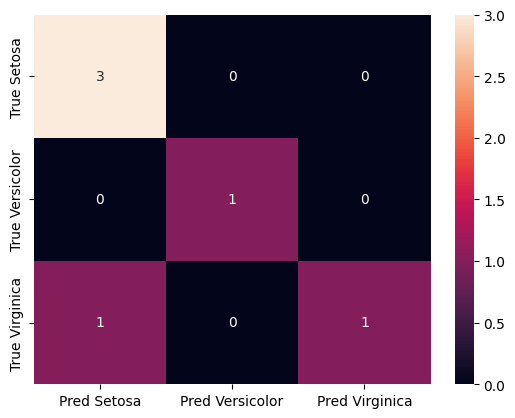

In [71]:
from matplotlib import pyplot
import seaborn as sns

# Only create the confusion matrix when our iris_predictions feature group has examples of all 3 iris flowers
if results.shape == (3,3):

    df_cm = pd.DataFrame(results, ['True Setosa', 'True Versicolor', 'True Virginica'],
                         ['Pred Setosa', 'Pred Versicolor', 'Pred Virginica'])

    cm = sns.heatmap(df_cm, annot=True)

    fig = cm.get_figure()
    fig.savefig("../../assets/confusion_matrix.png") 
    df_cm
else:
    print("Run the batch inference pipeline more times until you get 3 different iris flowers")    